IMPORTS

In [16]:
import pandas as pd
import sklearn
import scipy
import sklearn.ensemble as forest
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as metrics
import sklearn.gaussian_process as kriging
import seaborn as sns
from tensorflow import keras
from sklearn import preprocessing
from sklearn.pipeline import Pipeline, TransformerMixin, FeatureUnion
from sklearn.preprocessing import *
from feature_engine import wrappers,outliers

# from feature_engine import
from sklearn.compose import ColumnTransformer
from sklearn import model_selection
from sklearn.gaussian_process import GaussianProcessRegressor
from feature_engine.creation import MathFeatures, RelativeFeatures
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import RFECV
import optuna
import json
import pickle

In [17]:
from tensorflow import keras
from scikeras.wrappers import KerasRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.gaussian_process.kernels import RBF
from lightgbm import LGBMRegressor

In [18]:
def rna_model(
    features_in=87,
    hidden_layer_units=32,
    optimizer=keras.optimizers.Adam,
    optimizer__learning_rate=0.001,
    dropout=0.4,
):
    rna_model = keras.models.Sequential()
    rna_model.add(keras.layers.Input(shape=(features_in,)))
    rna_model.add(keras.layers.Dense(units=(features_in + 12), activation="relu"))
    rna_model.add(keras.layers.Dense(units=hidden_layer_units))

    rna_model.add(keras.layers.Dropout(rate=dropout))

    rna_model.add(keras.layers.LeakyReLU())
    rna_model.add(keras.layers.Dense(units=hidden_layer_units))

    rna_model.add(keras.layers.LeakyReLU())

    rna_model.add(keras.layers.Dropout(rate=dropout))
    rna_model.add(keras.layers.Dense(units=1, activation="linear"))

    rna_model.compile(
        loss="mean_squared_error",
        optimizer=optimizer(learning_rate=optimizer__learning_rate),
    )

    return rna_model


class Regressor:
    def __init__(self):
        # self.n_estimators=n_estimators-
        # self.features_in = len(x.columns)
        self.random_state = 5
        # self.models = self._define_model()
        # self.models_names = list(self._define_model().keys())
        # self.params_ = self._models_params()
        
        pass

    rfecv_features = {
        "RandomForestRegressor": [
            "ReactionTemperature",
            "H2FlowRate",
            "ReactionTemperature^2",
            "H2FlowRate^2",
            "ReactionTemperature^3",
            "ReactionTemperature^2 ReactorVolume",
            "H2FlowRate^2 FeedPressure",
        ],
        "GradientBoostingRegressor": [
            "ReactionTemperature",
            "ReactionTemperature^2",
            "H2FlowRate^2",
            "ReactionTemperature^3",
            "ReactionTemperature^2 ReactorVolume",
            "H2FlowRate^3",
            "H2FlowRate^2 FeedPressure",
        ],
        "XGBRFRegressor": [
            "ReactionTemperature",
            "H2FlowRate",
            "ReactionTemperature^2",
            "H2FlowRate^2",
            "ReactionTemperature^2 ReactorVolume",
            "H2FlowRate^2 ReactorVolume",
            "H2FlowRate^2 FeedPressure",
        ],
        "LGBMRegressor": [
            "ReactionTemperature",
            "H2FlowRate",
            "ReactionTemperature FeedPressure",
            "ReactionTemperature^2 ReactorVolume",
            "H2FlowRate^2 SplitsValues",
            "H2FlowRate ReactorVolume^2",
        ],
    }
    def fit(self,X:pd.DataFrame,y=None):
        self.x=X
        return self
    def search_params(self):
        search_params = {
            "RandomForestRegressor": {
                "n_estimators": 1000,
                "min_samples_split": 5,
                "min_samples_leaf": 4,
                "max_depth": None,
                "bootstrap": True,
            },
            "GradientBoostingRegressor": {
                "subsample": 1.0,
                "n_estimators": 200,
                "min_samples_split": 2,
                "min_samples_leaf": 1,
                "max_depth": 3,
                "learning_rate": 0.1,
            },
            "XGBRFRegressor": {
                "subsample": 1.0,
                "reg_lambda": 0.5,
                "reg_alpha": 0.1,
                "max_depth": 3,
                "learning_rate": 0.1,
                "gamma": 0,
                "colsample_bytree": 0.8,
            },
            "LGBMRegressor": {
                "subsample": 0.8,
                "num_leaves": 31,
                "n_estimators": 200,
                "min_child_samples": 50,
                "max_depth": 3,
                "learning_rate": 0.1,
                "colsample_bytree": 1.0,
            },
            "RNA": {
                "optimizer__learning_rate": 0.001,
                "optimizer": keras.optimizers.SGD,
                "hidden_layer_units": 64,
                "dropout": 0.4,
            },
        }
        return search_params
    
        



    def _models_params(self):
        param_dict = {
            "RandomForestRegressor": {
                "bootstrap": [True, False],
                "max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
                # 'max_features': ['1.0', 'sqrt'],
                "min_samples_leaf": [1, 2, 4],
                "min_samples_split": [2, 5, 10],
                "n_estimators": [
                    200,
                    400,
                    600,
                    800,
                    1000,
                    1200,
                    1400,
                ],
            },
            "GradientBoostingRegressor": {
                "n_estimators": [100, 200, 300],
                "learning_rate": [0.01, 0.1, 0.5],
                "max_depth": [3, 5, 7],
                "subsample": [0.8, 1.0],
                "min_samples_split": [2, 5],
                "min_samples_leaf": [1, 2],
                # 'max_features': ['sqrt', 'log2']
            },
            "XGBRFRegressor": {
                "learning_rate": [0.1, 0.01, 0.001],  # Learning rate
                "max_depth": [3, 4, 5],  # Maximum depth of each tree
                "subsample": [
                    0.8,
                    0.9,
                    1.0,
                ],  # Subsample ratio of the training instances
                "colsample_bytree": [
                    0.8,
                    0.9,
                    1.0,
                ],  # Subsample ratio of columns when constructing each tree
                "reg_alpha": [0, 0.1, 0.5],  # L1 regularization term on weights
                "reg_lambda": [0, 0.1, 0.5],  # L2 regularization term on weights
                "gamma": [
                    0,
                    0.1,
                    0.5,
                ],  # Minimum loss reduction required to make a further partition on a leaf node
            },
            "LGBMRegressor": {
                "n_estimators": [100, 200, 300],  # Number of boosting rounds
                "learning_rate": [0.01, 0.05, 0.1],  # Step size shrinkage
                "max_depth": [
                    3,
                    5,
                    7,
                    -1,
                ],  # Maximum depth of trees (-1 means no limit)
                "num_leaves": [31, 50, 100],  # Maximum number of leaves in one tree
                "min_child_samples": [
                    20,
                    50,
                    100,
                ],  # Minimum number of data points in leaves
                "subsample": [0.8, 1.0],  # Row subsampling rate
                "colsample_bytree": [0.8, 1.0],  # Feature subsampling rate
            },
            "RNA": {
                "hidden_layer_units": [32, 64, 128, 256],
                "optimizer": [
                    keras.optimizers.Adam,
                    keras.optimizers.SGD,
                    keras.optimizers.RMSprop,
                ],
                "optimizer__learning_rate": [0.1, 0.01, 0.001, 0.0001],
                "dropout": [0.1, 0.2, 0.3, 0.4, 0.5],
            },
        }

        # return [random_forest_params,gradient_boosting_regressor_params,ada_boost_regressor_params,gaussian_process_paramns,svr_params,xgb_regressor_params]
        return param_dict

    def rna_model(hidden_layer_units, optimizer):
        rna_model = keras.models.Sequential()
        rna_model.add(keras.layers.Input(shape=(28,)))
        rna_model.add(keras.layers.Dense(units=(32), activation="relu"))
        rna_model.add(keras.layers.Dense(units=hidden_layer_units))

        rna_model.add(keras.layers.LeakyReLU())
        rna_model.add(keras.layers.Dense(units=hidden_layer_units))

        rna_model.add(keras.layers.LeakyReLU())
        rna_model.add(keras.layers.Dense(units=1, activation="linear"))

        rna_model.compile(loss="mean_squared_error", optimizer=optimizer)

        return rna_model
    
    def _define_model(self):
        models = {
            "RandomForestRegressor": RandomForestRegressor,
            "GradientBoostingRegressor": GradientBoostingRegressor,
            "XGBRFRegressor": XGBRegressor,
            "LGBMRegressor": LGBMRegressor,
            "RNA": KerasRegressor,
        }

        return models

Classes

In [19]:
class ColumnExtractor(TransformerMixin):
    def __init__(self,cols):
        self.cols=cols

    def transform(self,X:pd.DataFrame,y=None):
        self.x=X[self.cols]
        return self.x

    def fit(self,X,y=None):
        self.x=X
        return self
    
    # def inverse_transform(self):
        




Tratamento Dos Dados

In [20]:
dfx = pd.DataFrame(
    pd.read_csv(
        filepath_or_buffer="DadosMetamodelagemX4.csv",
        delimiter=",",
        index_col=False,
        names=[
            "ReactionTemperature",
            "H2FlowRate",
            "SplitsValues",
            "RefluxRatio",
            "ReactorVolume",
            "FeedPressure",
            "NANx",
        ],
    )
)
dfy = pd.DataFrame(
    pd.read_csv(
        "DadosMetamodelagemY4.csv",
        delimiter=",",
        names=[
            "ISBL",
            "CustoMateriaPrima",
            "CustoUtilidades",
            "Methanol",
            "IsValid",
            "IsConverged",
            "StreamConvergeance",
            "NANy",
        ],
    )
)
dfy["Methanol"] = dfy["Methanol"] * 32 * 575 / 1000


dft = pd.DataFrame.join(dfx, dfy)
dft.drop(dft.loc[dft["StreamConvergeance"] == False].index, inplace=True)
dft.drop(
    columns=["NANx", "NANy", "IsValid", "StreamConvergeance", "IsConverged"],
    inplace=True,
)
dft.reset_index(inplace=True, drop=True)
dft.astype(dtype=float, copy=True)
dft["ISBL"] = dft["ISBL"].astype(float)

df_isbl = dft["ISBL"]
df_osbl = df_isbl * 0.35
df_opex = (dft["CustoMateriaPrima"] + dft["CustoUtilidades"])*24*30*12
df_capex = (
    (
        df_isbl
        + df_osbl
        + 0.20 * (df_osbl + df_isbl)
        + 0.30 * (df_osbl + df_isbl)
        + 0.15 * (df_osbl + df_isbl)
    )
    
)
df_tac=(df_capex*0.20 + df_opex)/24/30/12
df_profit = pd.DataFrame(dft["Methanol"] - df_tac, columns=["Profit"])

to_drop = ["ISBL", "CustoMateriaPrima", "CustoUtilidades", "Methanol"]
dft.drop(labels=to_drop, inplace=True, axis=1)
dft = dft.join(df_profit)

target = ["Profit"]
features = [
    "ReactionTemperature",
    "H2FlowRate",
    "SplitsValues",
    "RefluxRatio",
    "ReactorVolume",
    "FeedPressure",
]

# dft.drop(dft[(dft[target]<-100000).values].index,axis=0,inplace=True)
# dft.reset_index(inplace=True,drop=True)

x_train, x_test, y_train, y_test = model_selection.train_test_split(
    dft[features], dft[target], test_size=0.33
)
train_test_data_list = [x_train, x_test, y_train, y_test]
for i in train_test_data_list:
    i.reset_index(inplace=True, drop=True)
df_train = x_train.join(y_train)
df_test = x_test.join(y_test)



HeatMap Das Correlações

<Axes: >

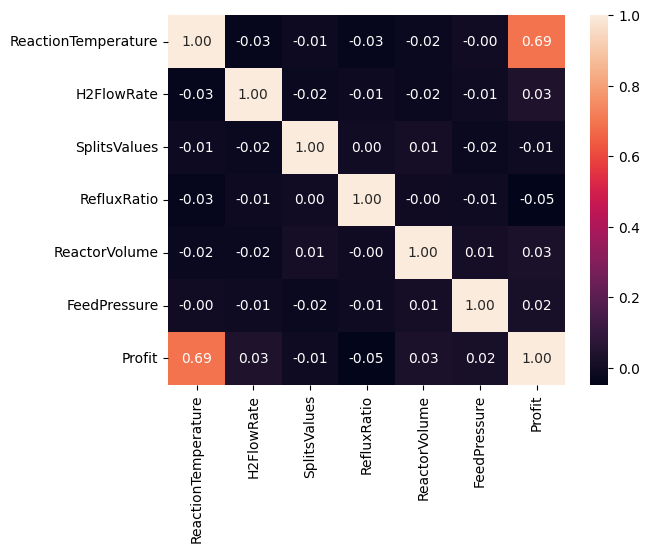

In [21]:
sns.heatmap(dft.corr(), annot=True, annot_kws={"size": "10"}, fmt=".2f")

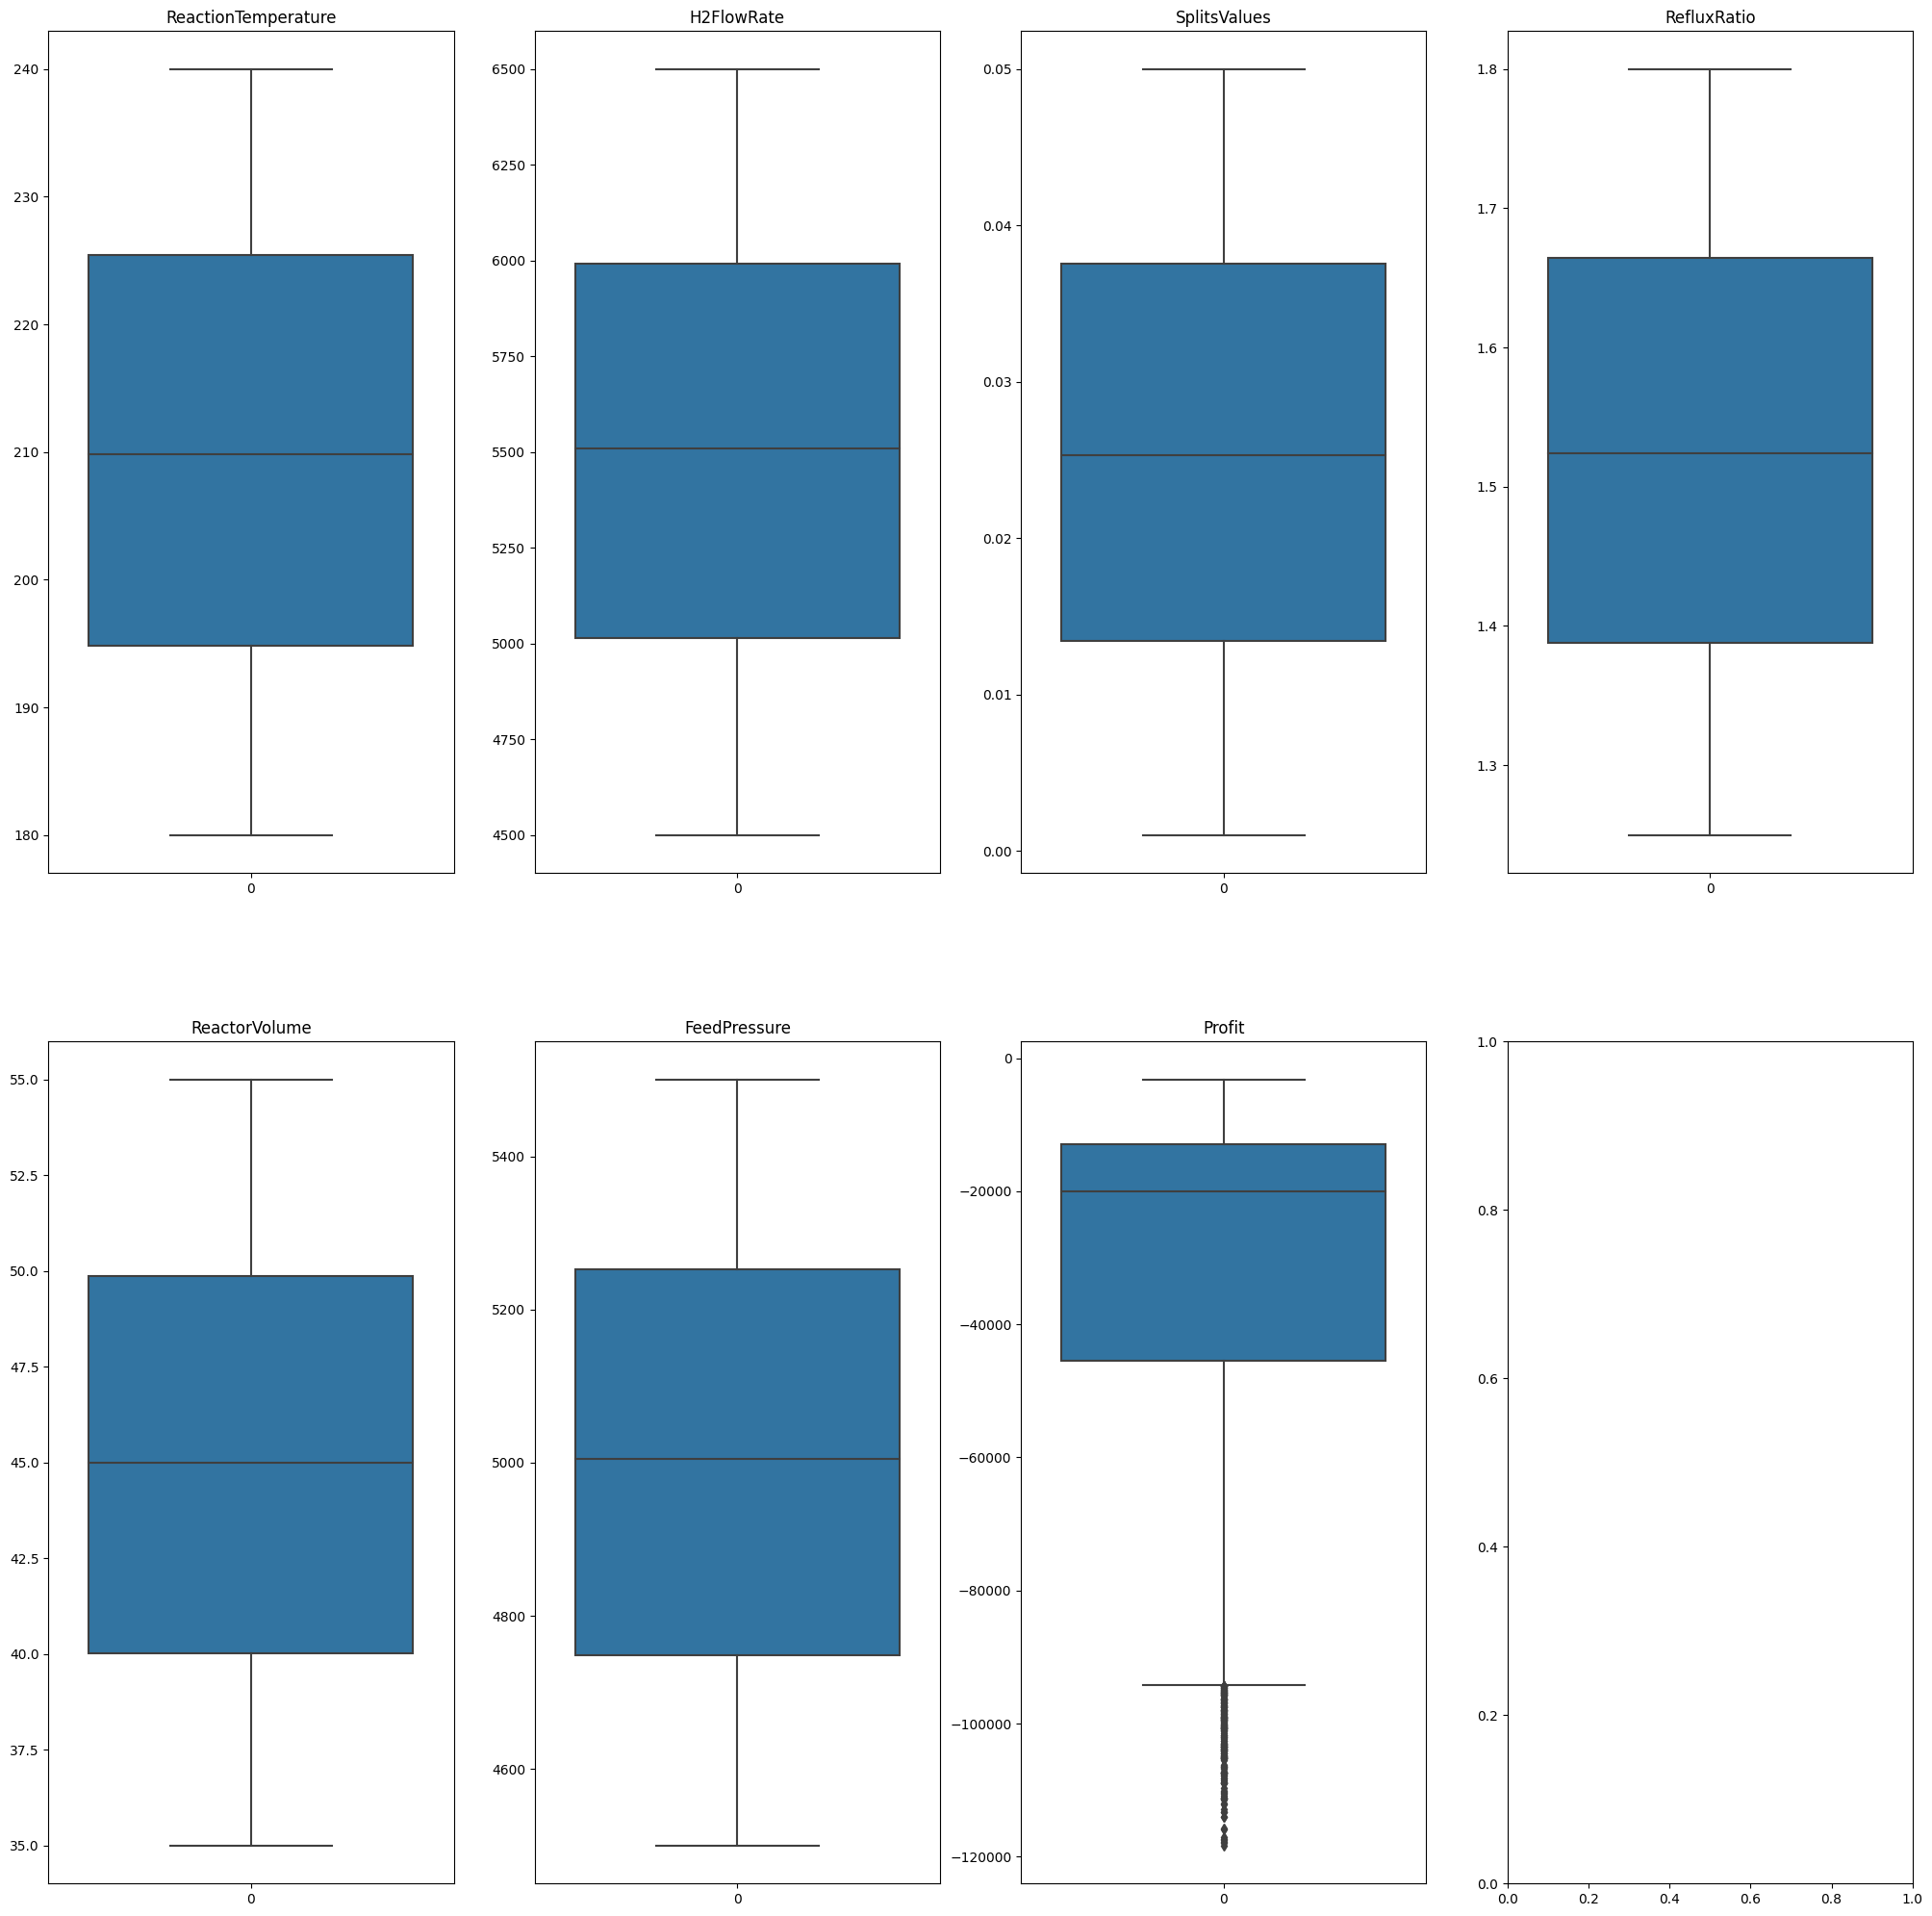

In [22]:
fig, axes = plt.subplots(2, 4, figsize=(25, 25))
axesf = axes.flatten()
for i, columns in enumerate(dft.columns.to_list()):
    ax = axesf[i]
    ax.set_title(columns)
    sns.boxplot(df_train[columns], ax=ax)

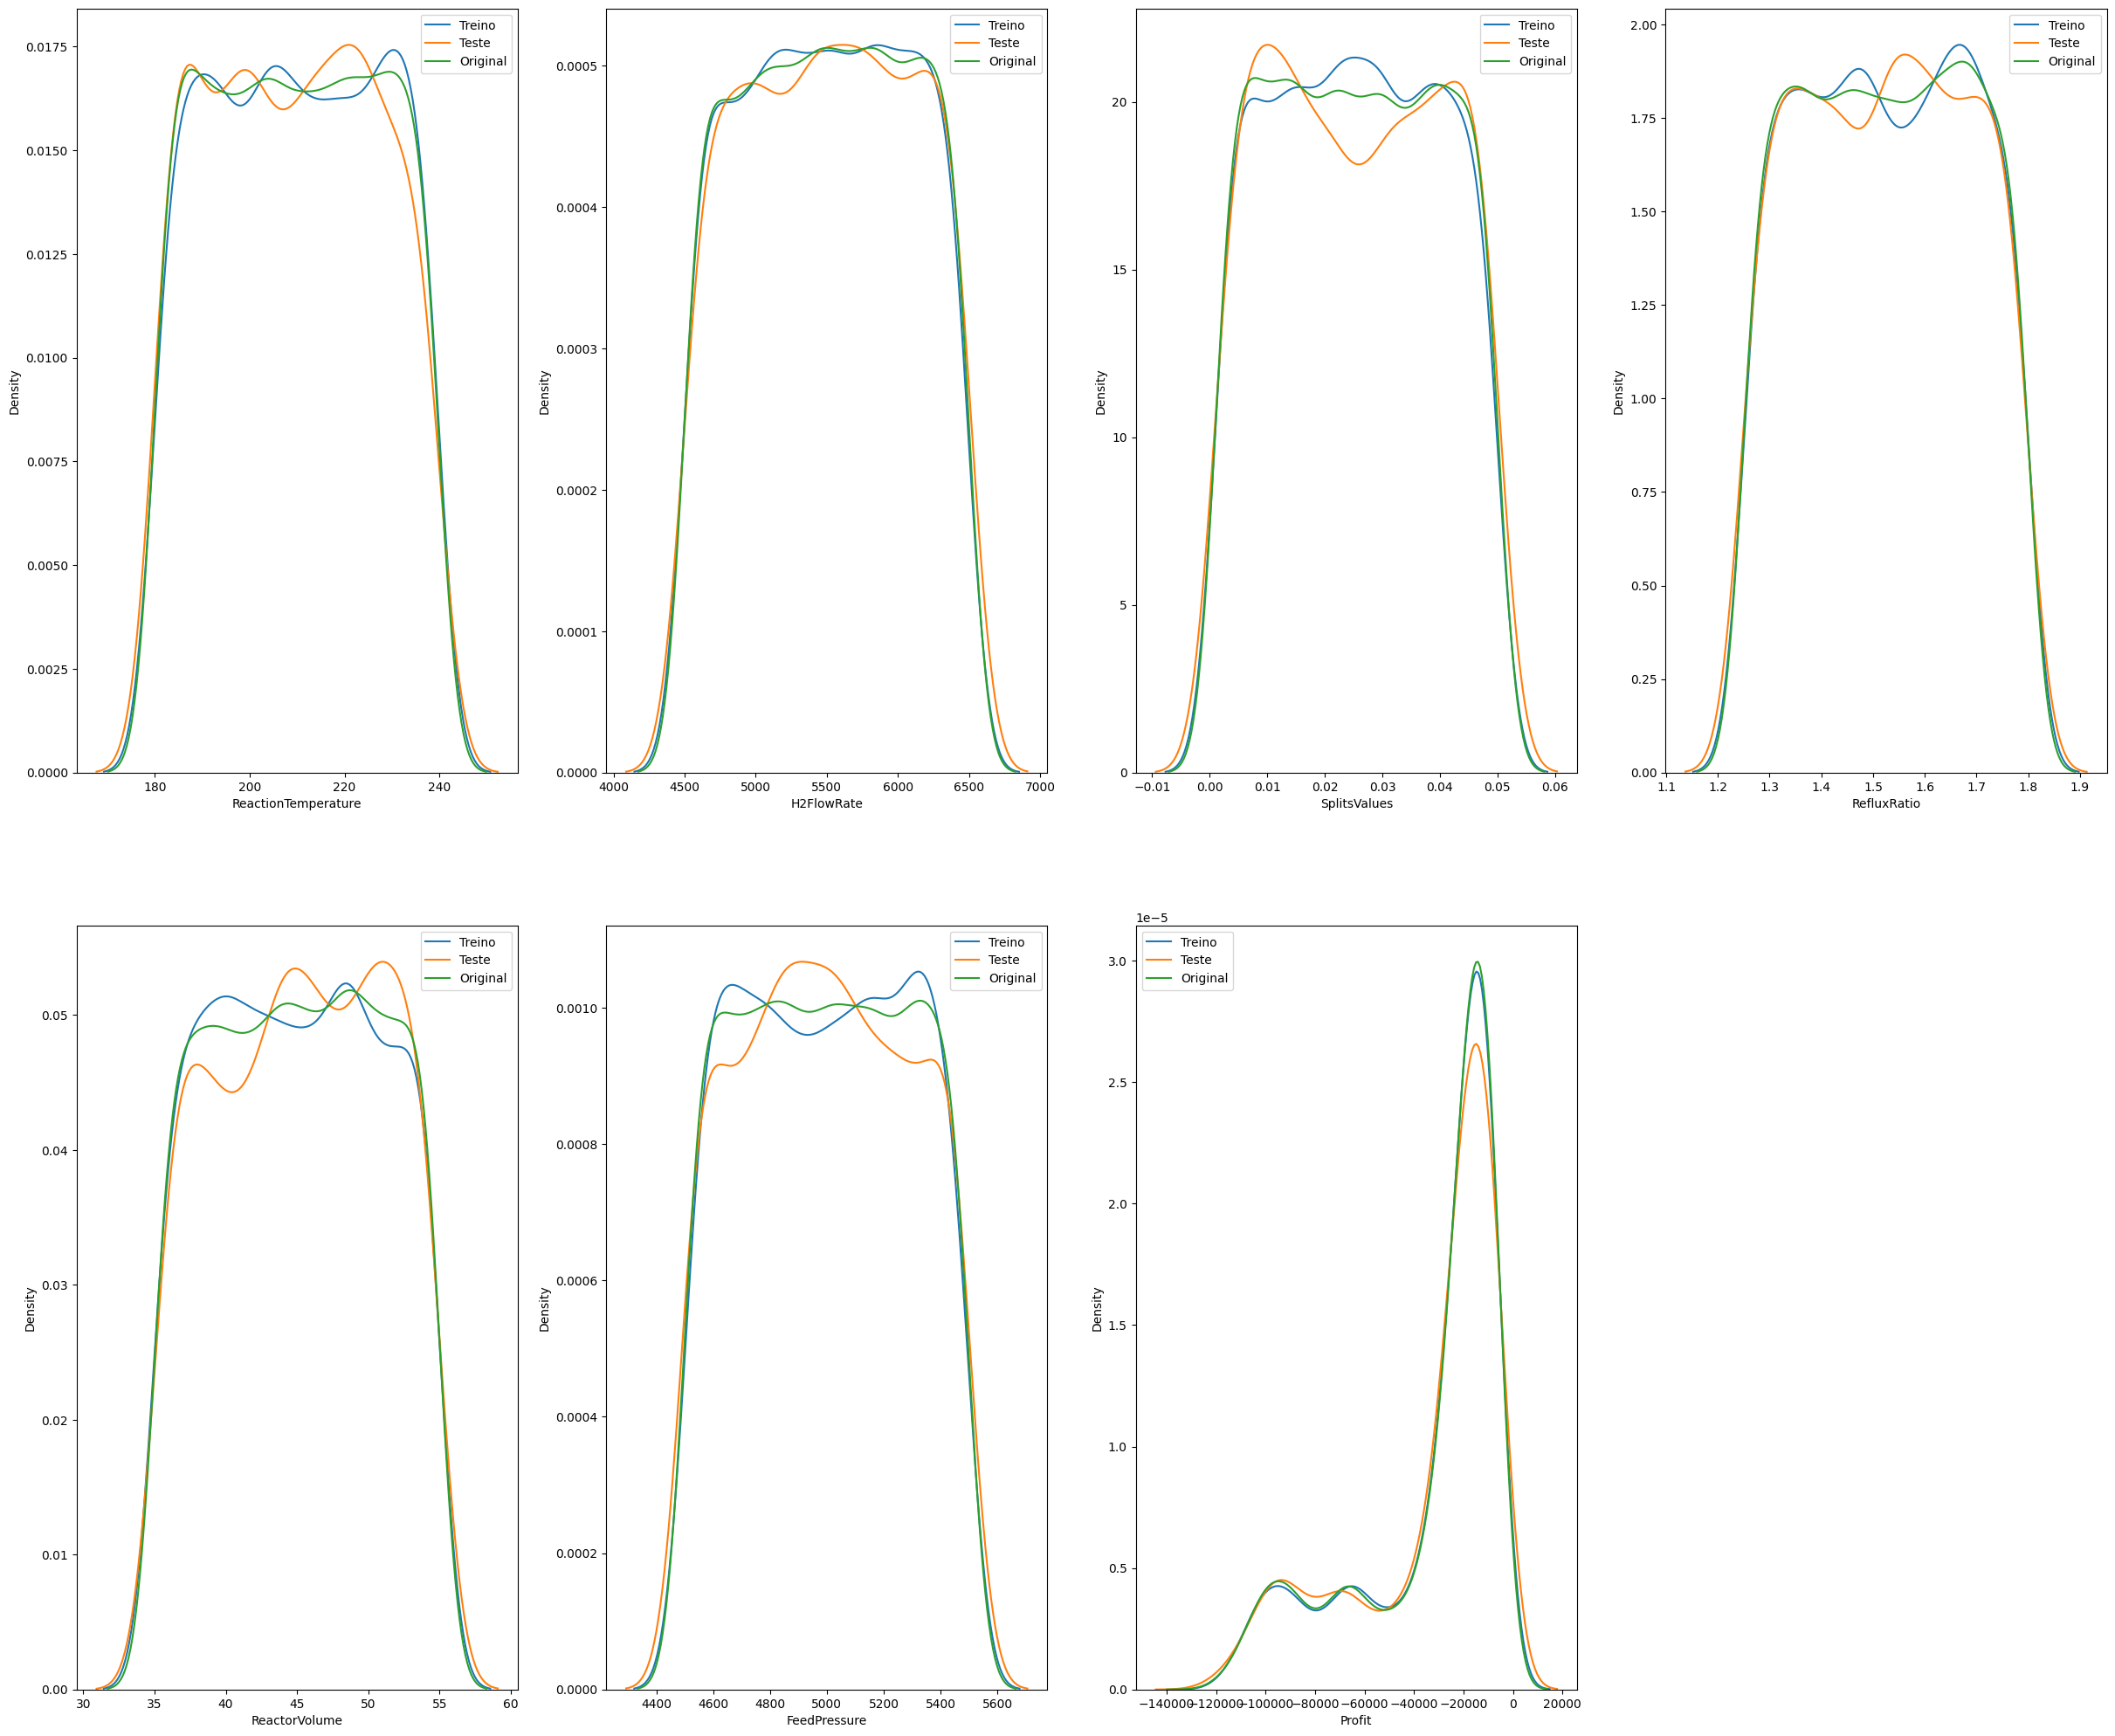

In [23]:
fig, axes = plt.subplots(2, 4, figsize=(30, 25))
fig.delaxes(axes[1, 3])
axesf = axes.flatten()
for i, columns in enumerate(dft.columns.to_list()):
    ax = axesf[i]
    sns.kdeplot(df_train[columns], ax=ax)
    sns.kdeplot(df_test[columns], ax=ax)
    sns.kdeplot(dft[columns], ax=ax)
    ax.legend(["Treino", "Teste", "Original"])

In [24]:
with open('models_parameters.json','r') as mp:
    models_parameters=dict(json.load(mp))

Data engineering e análise dos modelos

In [25]:
# x_train_trans = x_train
# x_test_trans = x_test
# y_train_trans = y_train
# y_test_trans = y_test


# # target_transformer = Pipeline([
# #     # ("BoxCox", preprocessing.PowerTransformer(method="box-cox", copy=False)),
# #     ("target_transformer", RobustScaler())
# #     ])

# # target_transformer.set_output(transform="pandas")
# # y_train_trans = target_transformer.fit_transform(y_train_trans)
# # y_test_trans = target_transformer.transform(y_test_trans)

# feature_trans = Pipeline(
#     [
#         # ("PolynomialFeatures", PolynomialFeatures(3)),
#         ("LOG", FunctionTransformer(func=np.log)),
#         ("StandardScaler", StandardScaler()),
        
#     ]

# )
# feature_trans.set_output(transform="pandas")
# x_train_trans = feature_trans.fit_transform(x_train_trans)
# x_test_trans = feature_trans.transform(x_test_trans)
# rs=Regressor().fit(x_train_trans)
# models = rs._define_model()
# parameters = rs._models_params()
# best_params = {}
# scores = {}
# models_list = {}
# scoring={'r2':metrics.make_scorer(metrics.r2_score),'neg_mean_squared_error':metrics.make_scorer(metrics.mean_squared_error)}

# for name, model in models.items():
#     if name =='RNA':
#         gs = model_selection.cross_validate(
#             estimator=model(build_fn=rna_model,**{'features_in':len(x_train_trans.columns)},**models_parameters[name]),
#             X=x_train_trans,
#             y=np.ravel(y_train),
#             cv=3,
#             scoring=scoring,
#             verbose=0,)
#     else:
#         gs = model_selection.cross_validate(
#             estimator=model(**models_parameters[name]),
#             X=x_train_trans,
#             y=np.ravel(y_train),
#             cv=3,
#             scoring=scoring,
#             verbose=0,)
#     scores.update({name: gs["test_r2"]})
#     models_list.update({name: gs})
#     print("Modelo:{}\n score: {}".format(*[name, scores[name]]))

# print(scores)

In [26]:
# pd.DataFrame(scores).to_json(r'cv_scores.json')

RandomizedSearchCv 

In [27]:
# x_train_trans = x_train
# x_test_trans = x_test
# y_train_trans = y_train
# y_test_trans = y_test


# target_transformer = ColumnTransformer(
#     [   ('OutlierTrimmer',outliers.ArbitraryOutlierCapper(max_capping_dict=None,min_capping_dict={'Profit':}))
#         ("target_transformer", RobustScaler(),target),
        
#         # ("BoxCox", preprocessing.PowerTransformer(method="box-cox", copy=False)),
#     ]
# )
# target_transformer.set_output(transform="pandas")
# y_train_trans = target_transformer.fit_transform(y_train_trans)
# y_test_trans = target_transformer.transform(y_test_trans)

# feature_trans = Pipeline(
#     [
#         ("PolynomialFeatures", PolynomialFeatures(3, interaction_only=False)),
        
#         # ("LOG", FunctionTransformer(func=np.log)),
#         ("StandardScaler", StandardScaler()),
#     ]
# )
# feature_trans.set_output(transform="pandas")
# x_train_trans = feature_trans.fit_transform(x_train_trans)
# x_test_trans = feature_trans.transform(x_test_trans)

# regressor = Regressor(x=x_train_trans)
# models = regressor.models
# parameters = regressor._models_params()
# best_params = {}
# scores = {}
# models_list = {}
# # scoring={'r2':metrics.make_scorer(metrics.r2_score),'neg_mean_squared_error':metrics.make_scorer(metrics.mean_squared_error)}

# for name, model in models.items():

#     gs = RandomizedSearchCV(
#         estimator=model,
#         param_distributions=parameters[name],
#         cv=3,
#         scoring='r2',
#         verbose=2
#         )
#     gs.fit(x_train_trans,np.ravel(y_train_trans))
#     scores.update({name:gs.best_score_})
#     models_list.update({name:gs})
#     best_params.update({name:gs.best_params_})
#     print("Modelo:{}\n score: {}".format(*[name, scores[name]]))

# print(parameters)

RFECV features_to_drop

In [28]:
# x_train_trans = x_train
# x_test_trans = x_test
# y_train_trans = y_train
# y_test_trans = y_test


# target_transformer = Pipeline(
#     [
#         ("target_transformer", RobustScaler()),
#         # ("BoxCox", preprocessing.PowerTransformer(method="box-cox", copy=False)),
#     ]
# )
# target_transformer.set_output(transform="pandas")
# y_train_trans = target_transformer.fit_transform(y_train_trans)
# y_test_trans = target_transformer.transform(y_test_trans)
# rs=Regressor()
# # model = Pipeline(
# #     [
# #         ("PolynomialFeatures", PolynomialFeatures(3, interaction_only=False)),
        
# #         # ("LOG", FunctionTransformer(func=np.log)),
# #         ("StandardScaler", StandardScaler()),
# #         ('Regressor_fit',rs),
# #         ('model',rs._define_model()['RNA'])
    
# #     ]
# # )

# # features_to_drop={}
# # mod=model.fit(x_train_trans,y_train_trans)
# # mod
# # # gs=RFECV(model,cv=3, scoring='r2',)
# # # gs.fit(x_train_trans,np.ravel(y_train_trans))
# # # features_to_drop.update({name:gs.support_})

Optuna Parameter optimization

In [29]:
# x_train_trans = x_train
# x_test_trans = x_test
# y_train_trans = y_train
# y_test_trans = y_test


# target_transformer = Pipeline(
#     [
#         ("target_transformer", RobustScaler()),
#         # ("BoxCox", preprocessing.PowerTransformer(method="box-cox", copy=False)),
#     ]
# )
# target_transformer.set_output(transform="pandas")
# y_train_trans = target_transformer.fit_transform(y_train_trans)
# y_test_trans = target_transformer.transform(y_test_trans)

# models=Regressor()._define_model()
# selected_features=Regressor().rfecv_features
# feature_trans = Pipeline(
#     [
#         ("PolynomialFeatures", PolynomialFeatures(3, interaction_only=False)),
#         # ('ColumnExtractor',ColumnExtractor(selected_features[name])),
#         # ("LOG", FunctionTransformer(func=np.log)),
#         ("StandardScaler", StandardScaler()),
#         # ('model',models[name])

#     ]
# )   
# feature_trans.set_output(transform='pandas')
# x_train_trans = feature_trans.fit_transform(x_train_trans)
# x_test_trans = feature_trans.transform(x_test_trans)

# optuna_param_dist={"RandomForestRegressor": {
#             "n_estimators": optuna.distributions.IntDistribution(800,1200),
#             "min_samples_split":  optuna.distributions.IntDistribution(3,8),
#             "min_samples_leaf": optuna.distributions.IntDistribution(2,6),
           
#         },
#         "GradientBoostingRegressor": {
#             "subsample":  optuna.distributions.FloatDistribution(0.2,0.8),
#             "n_estimators":  optuna.distributions.IntDistribution(150,250),
#             "min_samples_split":  optuna.distributions.IntDistribution(2,8),
#             "min_samples_leaf": optuna.distributions.IntDistribution(2,8),
#             "max_depth": optuna.distributions.IntDistribution(2,8),
#             "learning_rate": optuna.distributions.FloatDistribution(0.01,0.5),
#         },
#         "XGBRFRegressor": {
#             "subsample": optuna.distributions.FloatDistribution(0.2,0.8),
#             "reg_lambda": optuna.distributions.FloatDistribution(0.2,0.7),
#             "reg_alpha": optuna.distributions.FloatDistribution(0.08,0.5),
#             "max_depth": optuna.distributions.IntDistribution(2,8),
#             "learning_rate": optuna.distributions.FloatDistribution(0.01,0.5),
#             "gamma": optuna.distributions.IntDistribution(1,3),
#             "colsample_bytree": optuna.distributions.FloatDistribution(0.2,0.8),
#         },
#         "LGBMRegressor": {
#             "subsample": optuna.distributions.FloatDistribution(0.2,0.8),
#             "num_leaves": optuna.distributions.IntDistribution(25,35),
#             "n_estimators": optuna.distributions.IntDistribution(150,250),
#             "min_child_samples": optuna.distributions.IntDistribution(35,60),
#             "max_depth": optuna.distributions.IntDistribution(2,10),
#             "learning_rate": optuna.distributions.FloatDistribution(0.01,0.5),
#             "colsample_bytree":optuna.distributions.FloatDistribution(0.2,0.8),
#         },
#         "RNA": {
#             "optimizer__learning_rate": optuna.distributions.FloatDistribution(0.0001,0.01),
#             # "optimizer": keras.optimizers.SGD,
#             "hidden_layer_units": optuna.distributions.IntDistribution(32,80),
#             "dropout": optuna.distributions.FloatDistribution(0.2,0.6),
#         },
#     }

# optuna_scores={}
# optuna_params={}
# for name,model in Regressor()._define_model().items():
#     if name=='RNA':
#         # x_train_trans_selected_features=x_train_trans[Regressor.rfecv_features[name]]
#         optuna_search=optuna.integration.OptunaSearchCV(estimator=model,param_distributions=optuna_param_dist[name],cv=5,verbose=2,scoring='r2')
#         optuna_search.fit(x_train_trans,np.ravel(y_train_trans))
#         trial=optuna_search.study_.best_trial
#         params=optuna_search.study_.best_params
#         print('best trial:{} '.format(trial))
#         optuna_scores.update({name:trial})
#         optuna_params.update({name:params})
#     else:
#         None
    



Perpetuação dos modelos

In [32]:
with open('models_features_selected.json','r') as fs:
    features_selected=dict(json.load(fs))
with open('models_parameters.json','r') as mp:
    models_parameters=dict(json.load(mp))

model_dict={}

feature_transformer_dict={}



for name,model in Regressor()._define_model().items():
      
    if name!='RNA':
        model_pipeline=Pipeline([
                        ('Polinomial_features',PolynomialFeatures(3)),
                        ('StandardScaler',StandardScaler()),
                        # ('features_selected',ColumnExtractor(cols=features_selected[name])),
                        ('model',model(**models_parameters[name]))
                        ])
        # xt=feature_pipeline.fit_transform(x_train,y_train_t)
        model_pipeline.fit(x_train,np.ravel(y_train))
    else:
        model_pipeline=Pipeline([
                        ('Polinomial_features',PolynomialFeatures(3)),
                        ('StandardScaler',StandardScaler()),
                        # ('features_selected',ColumnExtractor(features_selected[name])),
                        ('model',model(build_fn=rna_model,**models_parameters[name],**{'features_in':84}))
                        ])
        # feature_pipeline.named_steps['Polinomial_features'].set_output(transform='pandas')
        # feature_pipeline.named_steps['StandardScaler'].set_output(transform='pandas')
        model_pipeline.fit(x_train,np.ravel(y_train))
    
    model_dict.update({name:model_pipeline})
    # target_transformer_dict.update({name:target_transformer})
# with open("models.pkl", 'wb') as file:
    
#     pickle.dump(model_dict,file)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21165
[LightGBM] [Info] Number of data points in the train set: 2691, number of used features: 83
[LightGBM] [Info] Start training from score -33180.836481
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Tempo fitted models

In [45]:
time_model_predict={}
import time 

for name,models in model_dict.items():
    
    start=time.time()
    models.predict(X=x_train.values.reshape(-1,6)[30:130])
    end=time.time()
    time_model_predict.update({name:(start-end)})

c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(
c:\Users\LuanNogueira\Downloads\Ic-Metamodelagem\pibicvenv\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have v